# Feature Importance

In [1]:
from sklearn.inspection import permutation_importance
from sklearn.neural_network import MLPClassifier
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier
from scipy.stats import mannwhitneyu
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


sns.set_theme(style="whitegrid", context="paper", palette="Greys", font_scale=1.5)

In [2]:
labels = ['statistical_parity', 'equal_opportunity', 'average_odds']
data = pd.read_csv('../data/bias_symptoms_logreg_reduced.csv', index_col=[0,1])
data.index = data.index.droplevel(0)

In [3]:
mlp = MLPClassifier(
    alpha=0.0001,
    hidden_layer_sizes=(50,),
    learning_rate="constant",
    learning_rate_init=0.01,
    max_iter=200,
)
rf = RandomForestClassifier(
    max_depth=10,
    max_features="log2",
    min_samples_leaf=1,
    min_samples_split=10,
    n_estimators=500,
)
xgb = XGBClassifier(
    colsample_bytree=0.8, gamma=0.2, learning_rate=0.05, max_depth=6, subsample=0.6
)

In [4]:
def train_model(metric):
    mlp.fit(data.drop(columns=labels), data[metric])
    rf.fit(data.drop(columns=labels), data[metric])
    xgb.fit(data.drop(columns=labels), data[metric])
    return mlp, rf, xgb

In [19]:
def plot_importance(result, ax, title):
    sorted_importances_idx = result['importances_mean'].argsort()
    importances = pd.DataFrame(
        result.importances[sorted_importances_idx].T,
        columns=data.drop(columns=labels).columns[sorted_importances_idx],
    )
    # fig, ax = plt.subplots(figsize=(2, 4))
    ax = importances.plot.box(vert=False, whis=10, color="black", ax=ax)
    #ax.axvline(x=0, color="k", linestyle="--")
    # ax.axhline(y=8.5, color="k", linestyle="--")
    ax.set_xlabel("AUC Loss")
    ax.set_title(title)
    return ax

def compute_statistical_difference(result):
    sorted_importances_idx = result["importances_mean"].argsort()
    importances = result.importances[sorted_importances_idx].T
    ris = []
    for i in range(importances.shape[1]):
        find = False
        for j in range(i + 1, importances.shape[1]):
                if not find:
                    test = mannwhitneyu(importances[:, i], importances[:, j])
                    if test[1] < 0.05:
                        print(
                            i+1, j+1,
                            # result["importances_mean"].index[sorted_importances_idx[i]],
                            # result["importances_mean"].index[sorted_importances_idx[j]],
                        )
                        find = True
                        ris.append((i+1, j+1))
    return ris

def compute_permutation(metric, xgb, rf, mlp):
    result_xgb = permutation_importance(
        xgb,
        data.drop(columns=labels),
        data[metric],
        scoring="roc_auc",
        n_jobs=-1,
        n_repeats=10,
    )
    result_rf = permutation_importance(
        rf,
        data.drop(columns=labels),
        data[metric],
        scoring="roc_auc",
        n_jobs=-1,
        n_repeats=10,
    )
    result_mlp = permutation_importance(
        mlp,
        data.drop(columns=labels),
        data[metric],
        scoring="roc_auc",
        n_jobs=-1,
        n_repeats=10,
    )
    return result_xgb, result_rf, result_mlp

## Statistical Parity

In [11]:
mlp_sp, rf_sp, xgb_sp = train_model('statistical_parity')

In [15]:
result_xgb_sp, result_rf_sp, result_mlp_sp = compute_permutation('statistical_parity', xgb_sp, rf_sp, mlp_sp)

In [20]:
xgb_stats = compute_statistical_difference(result_xgb_sp)
rf_stats = compute_statistical_difference(result_rf_sp)
mlp_stats = compute_statistical_difference(result_mlp_sp)

1 3
2 3
3 4
4 5
5 6
6 7
7 8
8 9
9 10
10 11
1 3
2 3
3 4
4 5
5 6
6 7
7 8
8 9
9 10
10 11
1 2
2 4
3 4
4 5
5 6
6 7
7 8
8 9
9 10
10 11


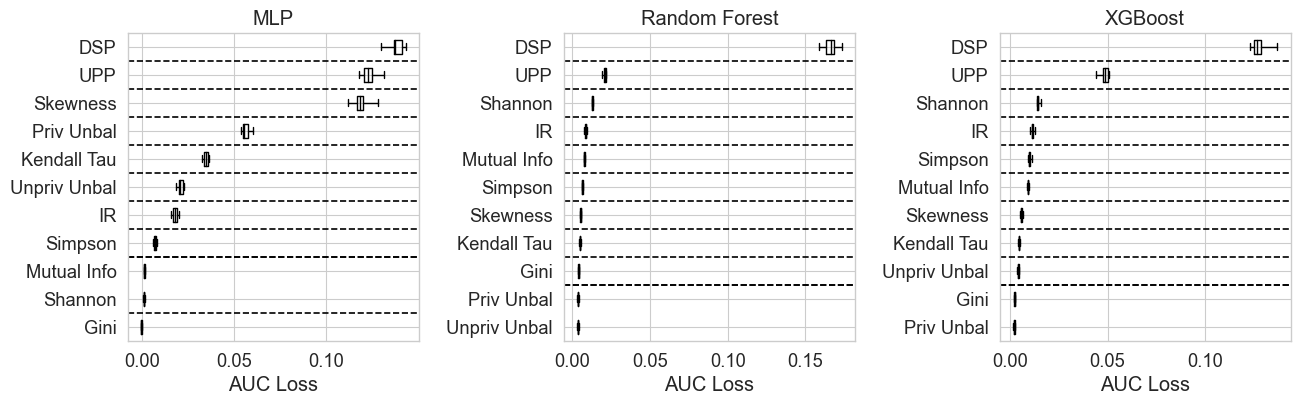

In [33]:
fig, axs = plt.subplots(1, 3, figsize=(15, 4))

ax_xgb = plot_importance(result_xgb_sp, axs[2], "XGBoost")
ax_rf = plot_importance(result_rf_sp, axs[1], "Random Forest")
ax_mlp = plot_importance(result_mlp_sp, axs[0], "MLP")

plt.subplots_adjust(wspace=0.5)

xgb_tick_labels = [
        "DSP",
        "UPP",
        "Shannon",
        "IR",
        "Simpson",
        "Mutual Info",
        "Skewness",
        "Kendall Tau",
        "Unpriv Unbal",
        "Gini",
        "Priv Unbal",
    ]
xgb_tick_labels.reverse()
ax_xgb.set_yticklabels(xgb_tick_labels)

rf_tick_labels = [
    "DSP",
    "UPP",
    "Shannon",
    "IR",
    "Mutual Info",
    "Simpson",
    "Skewness",
    "Kendall Tau",
    "Gini",
    "Priv Unbal",
    "Unpriv Unbal",
]
rf_tick_labels.reverse()
ax_rf.set_yticklabels(rf_tick_labels)

mlp_tick_labels = [
    "DSP",
    "UPP",
    "Skewness",
    "Priv Unbal",
    "Kendall Tau",
    "Unpriv Unbal",
    "IR",
    "Simpson",
    "Mutual Info",
    "Shannon",
    "Gini",
]
mlp_tick_labels.reverse()
ax_mlp.set_yticklabels(mlp_tick_labels)

for i, (a, b) in enumerate(xgb_stats):
    ax_xgb.axhline(y=b-0.5, color="k", linestyle="--")

for i, (a, b) in enumerate(rf_stats):
    ax_rf.axhline(y=b - 0.5, color="k", linestyle="--")

for i, (a, b) in enumerate(mlp_stats):
    ax_mlp.axhline(y=b - 0.5, color="k", linestyle="--")

plt.savefig('figs/perm_importance_sp.pdf', bbox_inches='tight')
plt.show()

## Equal Opportunity

In [36]:
mlp_eo, rf_eo, xgb_eo = train_model("equal_opportunity")

In [37]:
result_xgb_eo, result_rf_eo, result_mlp_eo = compute_permutation(
    "equal_opportunity", xgb_eo, rf_eo, mlp_eo
)

In [38]:
xgb_stats = compute_statistical_difference(result_xgb_eo)
rf_stats = compute_statistical_difference(result_rf_eo)
mlp_stats = compute_statistical_difference(result_mlp_eo)

1 2
2 3
3 4
4 5
5 7
6 7
7 8
8 9
9 10
10 11
1 2
2 3
3 4
4 5
5 6
6 8
7 8
8 9
9 10
10 11
1 2
2 3
3 4
4 5
5 6
6 7
7 8
8 11
9 11
10 11


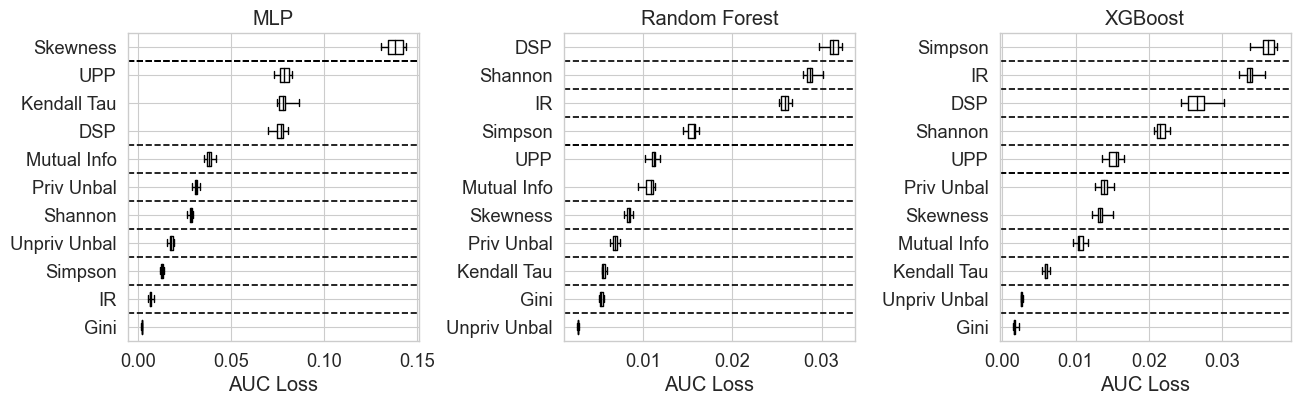

In [40]:
fig, axs = plt.subplots(1, 3, figsize=(15, 4))

ax_xgb = plot_importance(result_xgb_eo, axs[2], "XGBoost")
ax_rf = plot_importance(result_rf_eo, axs[1], "Random Forest")
ax_mlp = plot_importance(result_mlp_eo, axs[0], "MLP")

plt.subplots_adjust(wspace=0.5)

xgb_tick_labels = [
    "Simpson",
    "IR",
    "DSP",
    "Shannon",
    "UPP",
    "Priv Unbal",
    "Skewness",
    "Mutual Info",
    "Kendall Tau",
    "Unpriv Unbal",
    "Gini",
]
xgb_tick_labels.reverse()
ax_xgb.set_yticklabels(xgb_tick_labels)

rf_tick_labels = [
    "DSP",
    "Shannon",
    "IR",
    "Simpson",
    "UPP",
    "Mutual Info",
    "Skewness",
    "Priv Unbal",
    "Kendall Tau",
    "Gini",
    "Unpriv Unbal",
]
rf_tick_labels.reverse()
ax_rf.set_yticklabels(rf_tick_labels)

mlp_tick_labels = [
    "Skewness",
    "UPP",
    "Kendall Tau",
    "DSP",
    "Mutual Info",
    "Priv Unbal",
    "Shannon",
    "Unpriv Unbal",
    "Simpson",
    "IR",
    "Gini",
]
mlp_tick_labels.reverse()
ax_mlp.set_yticklabels(mlp_tick_labels)

for i, (a, b) in enumerate(xgb_stats):
    ax_xgb.axhline(y=b - 0.5, color="k", linestyle="--")

for i, (a, b) in enumerate(rf_stats):
    ax_rf.axhline(y=b - 0.5, color="k", linestyle="--")

for i, (a, b) in enumerate(mlp_stats):
    ax_mlp.axhline(y=b - 0.5, color="k", linestyle="--")

plt.savefig("figs/perm_importance_eo.pdf", bbox_inches="tight")
plt.show()

## Average Odds

In [43]:
mlp_ao, rf_ao, xgb_ao = train_model("average_odds")

In [44]:
result_xgb_ao, result_rf_ao, result_mlp_ao = compute_permutation(
    "average_odds", xgb_ao, rf_ao, mlp_ao
)

In [45]:
xgb_stats = compute_statistical_difference(result_xgb_ao)
rf_stats = compute_statistical_difference(result_rf_ao)
mlp_stats = compute_statistical_difference(result_mlp_ao)

1 2
2 3
3 5
4 5
5 6
6 7
7 8
8 9
9 10
10 11
1 3
2 3
3 4
4 5
5 6
6 7
7 8
8 9
9 10
10 11
1 2
2 3
3 5
4 5
5 6
6 7
7 8
8 9
9 10
10 11


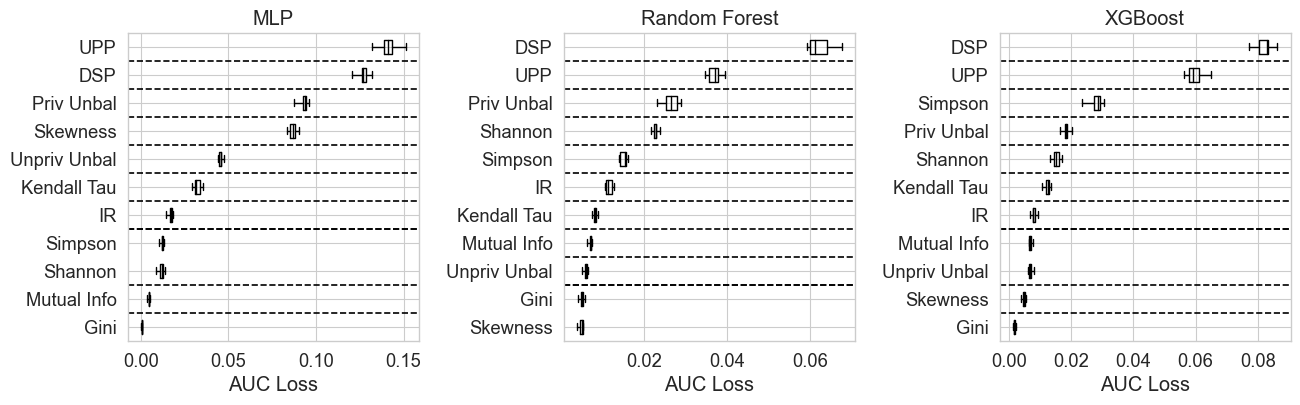

In [48]:
fig, axs = plt.subplots(1, 3, figsize=(15, 4))

ax_xgb = plot_importance(result_xgb_ao, axs[2], "XGBoost")
ax_rf = plot_importance(result_rf_ao, axs[1], "Random Forest")
ax_mlp = plot_importance(result_mlp_ao, axs[0], "MLP")

plt.subplots_adjust(wspace=0.5)

xgb_tick_labels = [
    "DSP",
    "UPP",
    "Simpson",
    "Priv Unbal",
    "Shannon",
    "Kendall Tau",
    "IR",
    "Mutual Info",
    "Unpriv Unbal",
    "Skewness",
    "Gini",
]
xgb_tick_labels.reverse()
ax_xgb.set_yticklabels(xgb_tick_labels)

rf_tick_labels = [
    "DSP",
    "UPP",
    "Priv Unbal",
    "Shannon",
    "Simpson",
    "IR",
    "Kendall Tau",
    "Mutual Info",
    "Unpriv Unbal",
    "Gini",
    "Skewness",
]
rf_tick_labels.reverse()
ax_rf.set_yticklabels(rf_tick_labels)

mlp_tick_labels = [
    "UPP",
    "DSP",
    "Priv Unbal",
    "Skewness",
    "Unpriv Unbal",
    "Kendall Tau",
    "IR",
    "Simpson",
    "Shannon",
    "Mutual Info",
    "Gini",
]
mlp_tick_labels.reverse()
ax_mlp.set_yticklabels(mlp_tick_labels)

for i, (a, b) in enumerate(xgb_stats):
    ax_xgb.axhline(y=b - 0.5, color="k", linestyle="--")

for i, (a, b) in enumerate(rf_stats):
    ax_rf.axhline(y=b - 0.5, color="k", linestyle="--")

for i, (a, b) in enumerate(mlp_stats):
    ax_mlp.axhline(y=b - 0.5, color="k", linestyle="--")

plt.savefig("figs/perm_importance_ao.pdf", bbox_inches="tight")
plt.show()